### 時間序列初步性質檢驗
References:
- [R語言自學系列(5) — 資料的時間序列性質檢驗](https://medium.com/r-%E8%AA%9E%E8%A8%80%E8%87%AA%E5%AD%B8%E7%B3%BB%E5%88%97/r%E8%AA%9E%E8%A8%80%E8%87%AA%E5%AD%B8%E7%B3%BB%E5%88%97-5-%E8%B3%87%E6%96%99%E7%9A%84%E6%99%82%E9%96%93%E5%BA%8F%E5%88%97%E6%80%A7%E8%B3%AA%E6%AA%A2%E9%A9%97-ebd367421122)
- [(弱)平穩隨機過程特性 與 線性非時變系統 (1) -Time domain property](https://ch-hsieh.blogspot.com/2013/08/lti-system.html)

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller

#### 成長率（Growth Rate）
時間序列資料的特性，當期觀測值（$x_t$）會是從前$k$筆觀測值（$x_{t-k}$）迭進而來的結果，因此可以透過$k$階差分的形式獲取每期觀測值（$x_i$）與其 （$x_{i-k}$）期對比的成長率。
- 一般算法：$\frac{x_t-x_{t-1}}{x_{t-1}}$

此外，我們也可以透過以對數的方式獲得差分的近似。
- 對數算法：$\log(x_t)$
    - 原因：$\log(1+x) \approx x$
    - 證明：
        - 基於 Talyor's Approximation
        $\frac{lim_{x\rightarrow0}(1+x)}{x} = lim_{x\rightarrow0}(\frac{1}{1+x})=1$ 
        - 因此
        $\begin{align} \Delta \log x_t & = \log(y_t) - \log(y_{t-1}) \\ & = \log(\frac{y_t}{y_{t-1}}) \\ & = \log(1 + \frac{y_t - y_{t-1}}{y_{t-1}}) \\ & \approx \frac{y_t - y_{t-1}}{y_{t-1}} \end{align}$
    - 結論：資料取對數後的結果，會近似於一般的變化率算法

In [8]:
data = pd.read_csv('../../data/AAOI.csv')
data = data[['Date', 'Close']]
data = data.rename(columns={'Date':'date', 'Close': 'price'})
data['date'] = data['date'].astype('datetime64[ns]')
data['log'] = np.log(data['price'])

# 新增 一般成長率
data['growth'] = data['price'].diff() / data['price'].shift()

# 新增 對數成長率
data['growth_log'] = data['log'].diff()

data.head()

,date,price,log,growth,growth_log
0,2019-09-04,9.10,2.208274,NaN,NaN
1,2019-09-05,9.79,2.281361,0.075824,0.073087
2,2019-09-06,10.30,2.332144,0.052094,0.050782
3,2019-09-09,10.58,2.358965,0.027184,0.026822
4,2019-09-10,11.44,2.437116,0.081285,0.078151


Text(0.5, 0.98, 'Fig 1.1 Normal versus Log Growth Rate')

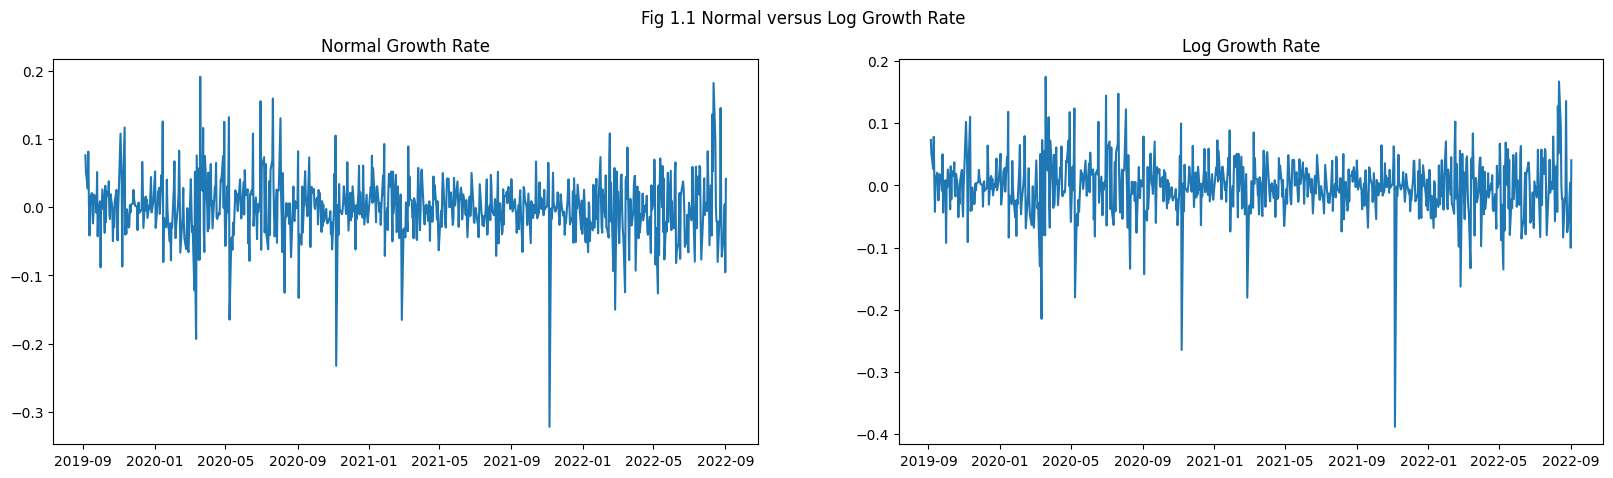

In [9]:
plt.figure(figsize=(20,5))
plt.subplot(121)
plt.plot(data['date'], data['growth'])
plt.title('Normal Growth Rate')
plt.subplot(122)
plt.plot(data['date'], data['growth_log'])
plt.title('Log Growth Rate')
plt.suptitle('Fig 1.1 Normal versus Log Growth Rate')

### 動差與自我相關係數（Auto Correlation Function）
一筆時間序列的自我相關係數越大，表示序列當期的觀測值（$x_t$）與前$K$期觀測值（$x_{t-k}$）關係越大
- K 階自我共變異數 
    $\begin{align} Cov(x_t, x_{t-k}) = E[(x-\mu_k)(x_t-\mu_{t-k})] \end{align}$

- K 階自我相關係數
    $\begin{align} \rho_{t,k} = \frac{Cov(x_t, x_{t-k})}{\sqrt{Var(x_t)Var(x_{x-t})}} \end{align}$


[1.         0.99115961 0.98220836 0.97299764 0.96392653 0.95486762
 0.9462429  0.93780856 0.92993838 0.92166242 0.91260099 0.90320908
 0.89427068 0.88515433 0.87596933 0.86685511 0.85800564 0.8495657
 0.84157171 0.83271277 0.82408541 0.81504809 0.80542409 0.79559383
 0.78630954 0.77730943 0.76837036 0.76059502 0.7527878 ]


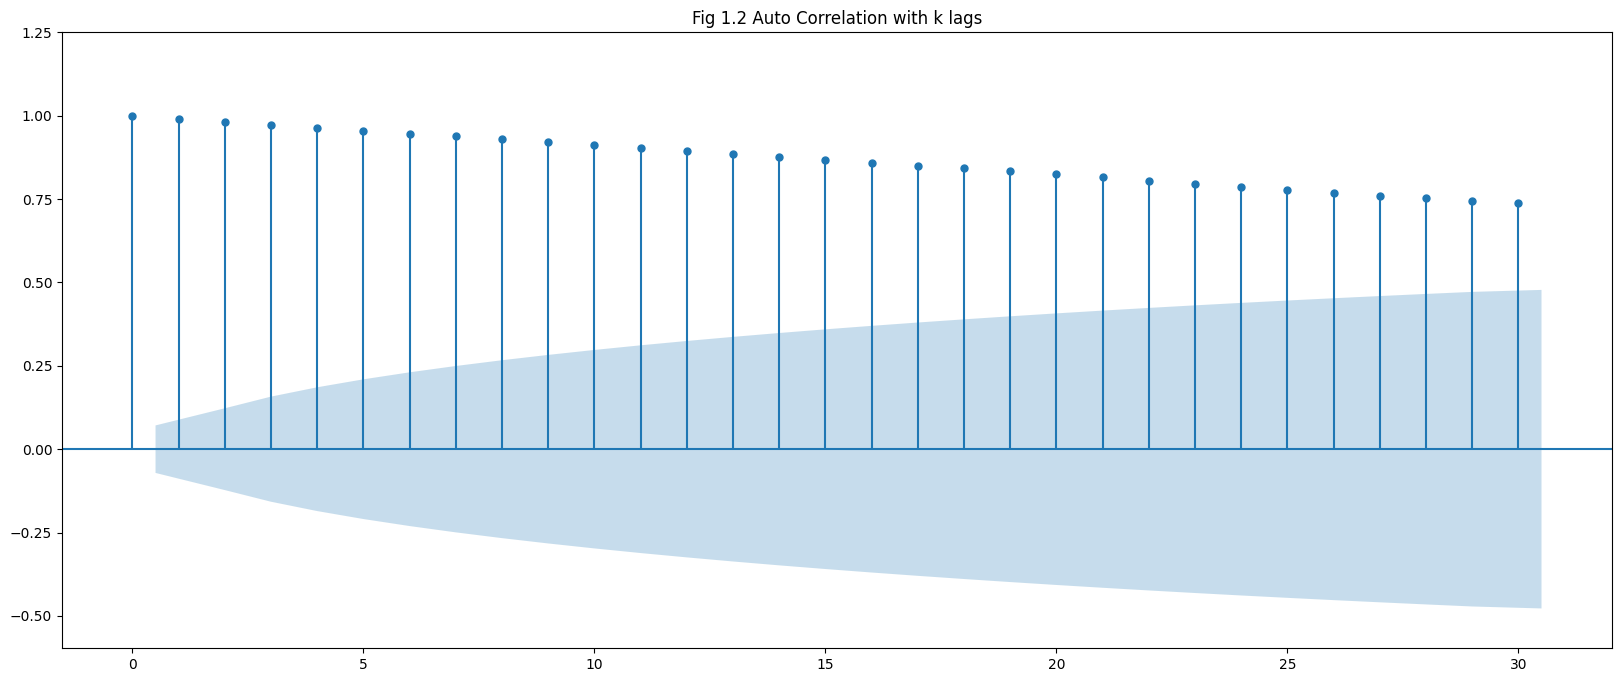

In [10]:
price_acf = acf(data['price'])

# 觀察滯後k期的自我相關係數情況
k = 30
print(price_acf[:k])
fig, ax = plt.subplots(figsize=(20, 8))
plot_acf(data['price'], lags=k, alpha=0.05, ax=ax, auto_ylims=True, title='Fig 1.2 Auto Correlation with k lags')
plt.show()

Fig 1.2 可觀察出此範例資料集：
- 滯後期數越多，其相關係數會逐漸遞減。
- 滯後30期後的資料保有約 0.75左右或以上的相關係數。

### 定態/平穩過程（Stationary Process）
- 定態/平穩表示一筆時間序列資料集對抗時間平移的能力，也就是 Time Invariant.
    - 設一筆時間序列資料為一個隨機過程，
- 時間序列的性質，我們往往希望它符合定態條件的（當往往這只是理想中的理想）。
    - 這是因為很大一部分的時間序列方法都或多或少會有一些定態假設.
    - 擁有這些假設是因為我們必須確認這筆時間序列是可預測的（Predictable）。
- 因此在分析一筆時間序列資料的初期，我們會去檢驗它是否為定態。
- 這會影響我們後續分析這筆資料集的流程與方法。
- 其中定態/平穩的性質也有區分為弱定態/平穩（Stationary）與強定態/平穩（Strict Stationary）。

##### 強定態/平穩（Strict Stationary）的條件
- 非常非常強的假設
- 要求任意 $t$ 與 $\Delta t$ 幾率分佈相同，兩者的期望值要求相同，且取函數後的期望值也需相同
    - 期望值 $E[X_t] = E[X_{t-\Delta t}]$
    - 設任一函數 $g(x)$，期望值 $E[g(X_t)] = E[g(X_{t-\Delta t})]$

##### 定態/平穩（Stationary）的條件
- 均數為常數，也就是一組序列資料的平均值並不會隨著時間改變，這很直觀的解釋了為甚麼我們看到很多時候一組資料可能有劇烈的上漲，但隨著時間變化又會下跌，換言之我們的資料是依據一個基準點在做波動的。
    - 只要求 $E[X_t]$ 與時間 $t$ 無關（i.e., $E[X_t]$ 為 constant）
- 變異數為有限值，當我們確立了第一點之後，我們必須給波動的範圍下一個範圍，而我們說這個範圍是其變異數必須有限。
- 其自我共變異數為 k 的函數，與 t 無關，也就是 $Cov(x_t,x_{t-k}) = f(k)$

##### 檢定 Stationary 的方法
- [Augmented Dickey-Fuller Test (ADF test)]((http://homepage.ntu.edu.tw/~sschen/Book/Slides/Ch6Unitroot.pdf))
    - H0：為單根 $\delta=0$
    - H1：為定態 $\delta<0$
    - 統計量 $ADF_{-t} = \frac{\hat{\delta}}{\sqrt{\hat{Var(\hat{\delta})}}}$
    - 常規用於作為 ADF test 的輸入類型：
        - Deflation by CPI
        - Logarithmic（取Log）
        - First Difference（差分1）
        - Seasonal Difference（差分12，或觀察該資料的週期數）
        - Seasonal Adjustment（差分12，或觀察該資料的週期數）

In [51]:
def process_and_plot(X):
    rolmean = X.rolling(window=7).mean()
    rolstd = X.rolling(window=7).std()
    plt.plot(data['date'], X)
    plt.plot(data['date'], rolmean)
    plt.plot(data['date'], rolstd)

def ADFtest(X):
    result = adfuller(X, autolag='AIC')

    report = pd.DataFrame(result, columns=['value'])
    report.index = ['test-statistic', 'p-value', 'usedlag', 'nobs', 'critical', 'icbest']
    return report

,value
test-statistic,-1.191086
p-value,0.677418
usedlag,0
nobs,756
critical,"{'1%': -3.439029421541435, '5%': -2.8653706489..."
icbest,701.742531


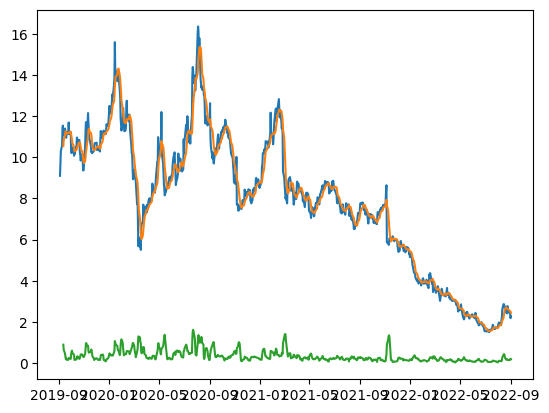

In [52]:
# 對原始資料做平穩性檢定
X = data['price']
process_and_plot(X)
report = ADFtest(X)
report

,value
test-statistic,-27.613932
p-value,0.0
usedlag,0
nobs,755
critical,"{'1%': -3.4390409569041207, '5%': -2.865375732..."
icbest,703.274669


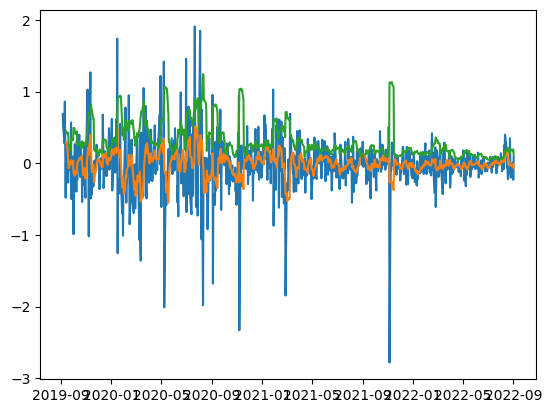

In [53]:
# 對一階差分資料做平穩性檢定
X = data['price'].diff()
process_and_plot(X)
report = ADFtest(X.dropna())
report